In [15]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Reading in the graph and the data**

In [7]:
df_time_between_stops = pd.read_csv("2030 Time Between Stops By Line.csv")
display(df_time_between_stops)

# Create a dictionary mapping line numbers to travel times
line_to_time = dict(zip(df_time_between_stops["Line"], df_time_between_stops["Time Between Stops (mins)"]))

,Line,Time Between Stops (mins)
0,1.0,1.500
1,2.0,1.375
2,3.0,1.292
3,3.5,1.000
4,4.0,1.250
5,5.0,1.619
6,6.0,1.269
7,7.0,1.424
8,7.5,1.000
9,8.0,1.378


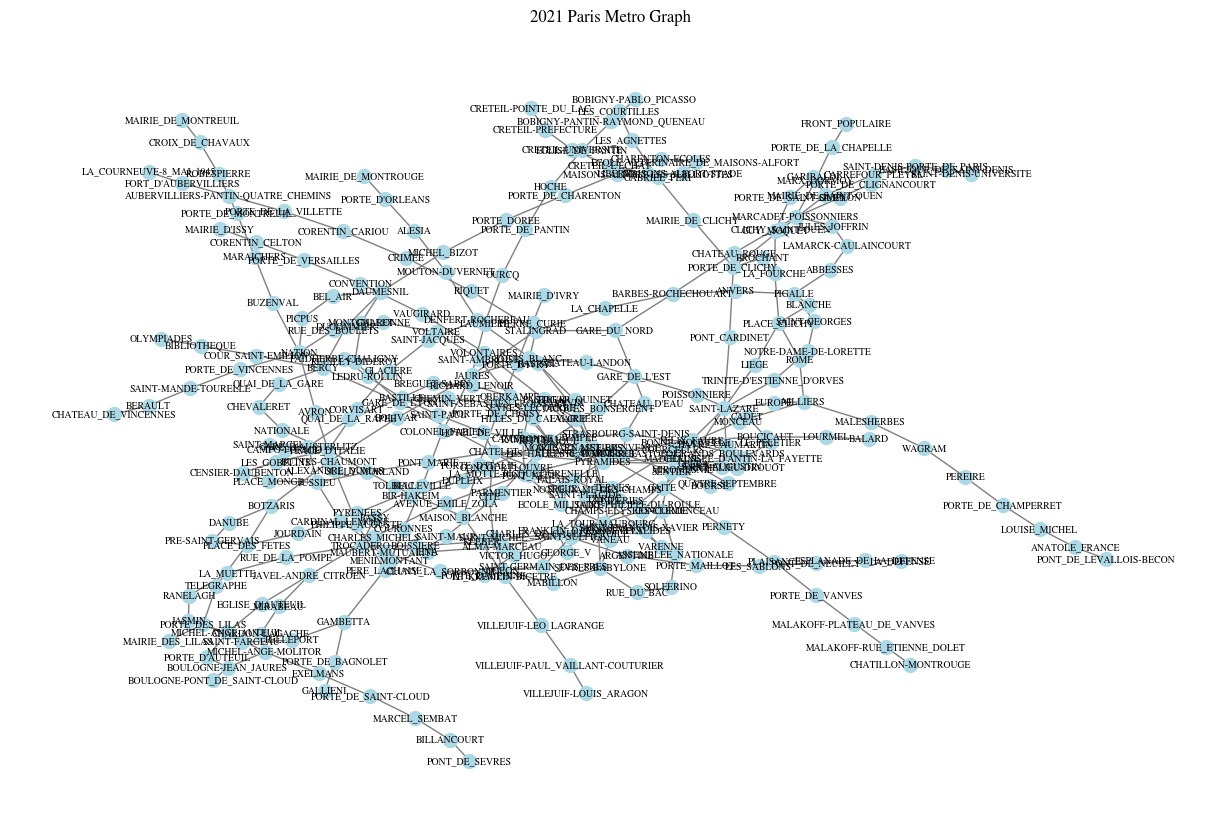

In [8]:
# Initialize an empty graph
G = nx.Graph()

# Read the graph file manually and parse edges
with open("graph_all_lines.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split(" ", 2)  # Split into first two parts + label dictionary
        if len(parts) == 3:
            node1, node2, attr_str = parts
            try:
                # Convert the attribute string into a dictionary
                attr_dict = eval(attr_str)  # Be cautious with eval() if the file is untrusted
                G.add_edge(node1, node2, **attr_dict)
            except SyntaxError:
                print(f"Skipping invalid line: {line.strip()}")

# Add traversal time as an edge attribute based on the line number
for u, v, data in G.edges(data=True):
    line = data.get("label")
    if line in line_to_time:
        G[u][v]["time"] = line_to_time[line]  # Assign travel time

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=7, font_family = 'STIXGeneral')
plt.title("2021 Paris Metro Graph")
plt.show()

In [9]:
df_2021 = pd.read_csv("all_2021_data.csv")
# Replace spaces with underscores in station names
df_2021["Station"] = df_2021["Station"].str.replace(" ", "_")

# Display the updated DataFrame
display(df_2021)

,ID,Network,Station,Traffic,First Line,Second Line,Third Line,Fourth Line,Fifth Line,Arrondissement for Paris,latitude,longitude
0,1,Metro,GARE_DU_NORD,34503097,4,5,NaN,NaN,NaN,10.0,48.880556,2.355000
1,2,Metro,SAINT-LAZARE,33128384,3,9,12,13.0,14.0,8.0,48.875490,2.326640
2,3,Metro,GARE_DE_LYON,28640475,1,14,A,NaN,NaN,12.0,48.844722,2.373889
3,4,Metro,MONTPARNASSE-BIENVENUE,20407224,4,6,12,13.0,NaN,14.0,48.843466,2.323072
4,5,Metro,GARE_DE_L'EST,15538471,4,5,7,NaN,NaN,10.0,48.876111,2.358333
...,...,...,...,...,...,...,...,...,...,...,...,...
299,301,Metro,BOLIVAR,367598,7bis,NaN,NaN,NaN,NaN,19.0,48.880502,2.374922
300,302,Metro,BUTTES-CHAUMONT,358301,7bis,NaN,NaN,NaN,NaN,19.0,48.878500,2.381772
301,303,Metro,PRE-SAINT-GERVAIS,282626,7bis,NaN,NaN,NaN,NaN,19.0,48.880250,2.398910
302,304,Metro,PELLEPORT,229524,3bis,NaN,NaN,NaN,NaN,20.0,48.868671,2.401752


## **Used in the final report - Line 1 Graphs**

In [18]:
# Last edit: 4/6/25 (for some reason the labels aren't working)

def calculate_transfers(graph, source_stations, target_stations):
    """
    Calculates the number of transfers needed to travel between stations.

    Args:
        graph: The graph representing the network.
        source_stations: A list of source station names.
        target_stations: A list of target station names.

    Returns:
        A dictionary where keys are (source_station, target_station) tuples
        and values are the number of transfers needed.
    """
    transfers_needed = {}
    for source_station in source_stations:
        for target_station in target_stations:
            if source_station == target_station:
                transfers_needed[(source_station, target_station)] = 0  # No transfer needed if source and target are the same
                continue

            # Find shortest path
            shortest_path = nx.shortest_path(graph, source=source_station, target=target_station)

            # Calculate transfers (number of line changes)
            num_transfers = 0
            current_line = None  # Keep track of the current line
            for i in range(len(shortest_path) - 2):  # Iterate up to the second-to-last station
                current_edge = (shortest_path[i], shortest_path[i + 1])
                next_edge = (shortest_path[i + 1], shortest_path[i + 2])

                # Get line numbers from edge labels
                current_line_num = graph.get_edge_data(*current_edge).get("label")
                next_line_num = graph.get_edge_data(*next_edge).get("label")

                # If line numbers are different, increment transfers
                if current_line_num != next_line_num:
                    num_transfers += 1

            transfers_needed[(source_station, target_station)] = num_transfers

    return transfers_needed

def find_stations_on_line(graph, line_number):
    """
    Finds all stations on a specific line in the graph.

    Args:
        graph: The graph representing the network.
        line_number: The line number to search for.

    Returns:
        A list of station names on the specified line.
    """
    stations_on_line = set()  # Use a set to avoid duplicates
    for u, v, data in graph.edges(data=True):
        if data.get("label") == line_number:
            stations_on_line.add(u)
            stations_on_line.add(v)
    return list(stations_on_line)

# Example usage:
# Assuming your graph is called 'G'
line1_stations = find_stations_on_line(G, "1")  # Replace "1" with the actual line number representation in your data
print(line1_stations)

# Example usage:
# Assuming you have a graph called 'G' and a list of all stations called 'all_stations'
# transfers_for_line_1 = calculate_transfers(G, all_stations, all_stations)
# print(transfers_between_stations)

[]


In [ ]:
# Create a new DataFrame containing only Line 1 stations and their traffic
line1_traffic_df = df1[df1['Station'].isin(Line1_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line1_Stations_Ordered
line1_traffic_df = line1_traffic_df.set_index('Station').reindex(Line1_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(line1_traffic_df.index, line1_traffic_df['Traffic'], marker='s', color='#ffbe00')

# Customize the plot
plt.xlabel("Stations on Line 1")
plt.ylabel("Traffic in ten millions")
plt.title("Traffic at Stations on Line 1")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

In [ ]:
# Last edit: 1/21/25

# Filter df1 for Line 1 stations and their traffic
line1_traffic_df = df1[df1['Station'].isin(Line1_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line1_Stations_Ordered
line1_traffic_df = line1_traffic_df.set_index('Station').reindex(Line1_Stations_Ordered)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Reindex both DataFrames to match Line1_Stations_Ordered before plotting
total_transfers_by_source = total_transfers_by_source.reindex(Line1_Stations_Ordered)
line1_traffic_df = line1_traffic_df.reindex(Line1_Stations_Ordered)

# Plot Total Transfers (left y-axis)
ax1.plot(Line1_Stations_Ordered, total_transfers_by_source['Total Transfers'], marker='o', linestyle='--', color='#805f01', label='Total Transfers')  # Specify x-axis values
ax1.set_xlabel("Stations on Line 1")
ax1.set_ylabel("Total Transfers")
ax1.tick_params('y')

# Create a second y-axis (right) for Traffic
ax2 = ax1.twinx()
ax2.plot(Line1_Stations_Ordered, line1_traffic_df['Traffic'], marker='s', color='#ffbe00', label='Traffic')  # Specify x-axis values
ax2.set_ylabel("Traffic")
ax2.tick_params('y')

ax1.set_xticklabels([])
ax1.set_xticks(range(len(Line1_Stations_Ordered)))
ax1.set_xticklabels(Line1_Stations_Ordered, rotation=45, ha='right')

# Customize the plot
plt.title("Total Transfers and Traffic at Stations on Line 1")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add legend
fig.legend(loc='upper left')  # Adjust location as needed

plt.show()

## **Used in the final report - Line 4 Graphs**

In [ ]:
# Last edit: 1/21/25

def calculate_transfers(graph, source_stations, target_stations):
    """
    Calculates the number of transfers needed to travel between stations.

    Args:
        graph: The graph representing the network.
        source_stations: A list of source station names.
        target_stations: A list of target station names.

    Returns:
        A dictionary where keys are (source_station, target_station) tuples
        and values are the number of transfers needed.
    """
    transfers_needed = {}
    for source_station in source_stations:
        for target_station in target_stations:
            if source_station == target_station:
                transfers_needed[(source_station, target_station)] = 0  # No transfer needed if source and target are the same
                continue

            # Find shortest path
            shortest_path = nx.shortest_path(graph, source=source_station, target=target_station)

            # Calculate transfers (number of line changes)
            num_transfers = 0
            current_line = None  # Keep track of the current line
            for i in range(len(shortest_path) - 1):
                station1 = shortest_path[i]
                station2 = shortest_path[i + 1]

                # Determine the line connecting station1 and station2
                line = None
                for line_stations in [Line1_Stations_Ordered, Line2_Stations_Ordered, Line3_Stations_Ordered, Line3bis_Stations_Ordered,
                                    Line4_Stations_Ordered, Line5_Stations_Ordered, Line6_Stations_Ordered, Line7_Stations_Ordered,
                                    Line7bis_Stations_Ordered, Line8_Stations_Ordered, Line9_Stations_Ordered, Line10_Stations_Ordered,
                                    Line11_Stations_Ordered, Line12_Stations_Ordered, Line13_Stations_Ordered, Line14_Stations_Ordered]:
                    if station1 in line_stations and station2 in line_stations:
                        line = line_stations # Assign the line if both stations are on it
                        break # Exit the loop if you found a line that contains both stations

                # If line is found and it's different from the current line, increment transfers
                if line and line != current_line:
                    num_transfers += 1
                    current_line = line

            transfers_needed[(source_station, target_station)] = num_transfers

    return transfers_needed

# Calculate transfers from Line 4 stations to all other stations
transfers_from_line4 = calculate_transfers(graph_all_lines, Line4_Stations_Ordered, list(graph_all_lines.nodes()))

# Print the results
#for (source, target), transfers in transfers_from_line1.items():
#    print(f"From {source} to {target}: {transfers} transfers")

# Create a DataFrame from the results
transfers_df = pd.DataFrame(transfers_from_line4.items(), columns=['(Source, Target)', 'Transfers'])
transfers_df[['Source', 'Target']] = pd.DataFrame(transfers_df['(Source, Target)'].tolist(), index= transfers_df.index) # Split the (Source, Target) column into two columns
transfers_df = transfers_df[['Source', 'Target', 'Transfers']] # Reorder the columns

# Group by 'Source' and sum the 'Transfers' column
total_transfers_by_source = transfers_df.groupby('Source')['Transfers'].sum().reset_index()

# Rename the 'Transfers' column to 'Total Transfers' for clarity
total_transfers_by_source.rename(columns={'Transfers': 'Total Transfers'}, inplace=True)

# Print the results
print(total_transfers_by_source)

## GRAPH

# Set 'Source' as the index and reindex to match Line4_Stations_Ordered
total_transfers_by_source = total_transfers_by_source.set_index('Source').reindex(Line4_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(total_transfers_by_source.index, total_transfers_by_source['Total Transfers'], marker='o', linestyle='--', color='#a0006e')

# Customize the plot
plt.xlabel("Stations on Line 4")
plt.ylabel("Total Transfers")
plt.title("Total Transfers Needed to Travel From Line 4 Stations")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

In [ ]:
# Create a new DataFrame containing only Line 4 stations and their traffic
line4_traffic_df = df1[df1['Station'].isin(Line4_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line4_Stations_Ordered
line4_traffic_df = line4_traffic_df.set_index('Station').reindex(Line4_Stations_Ordered)

# Plotting the data
plt.figure(figsize=(12, 6))

# Create the line plot
plt.plot(line4_traffic_df.index, line4_traffic_df['Traffic'], marker='s', color='#ad86a1')

# Customize the plot
plt.xlabel("Stations on Line 4")
plt.ylabel("Traffic in ten millions")
plt.title("Traffic at Stations on Line 4")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.show()

In [ ]:
# Last edit: 1/21/25

# Filter df1 for Line 4 stations and their traffic
line4_traffic_df = df1[df1['Station'].isin(Line4_Stations_Ordered)]

# Set 'Station' as the index and reindex to match Line4_Stations_Ordered
line4_traffic_df = line4_traffic_df.set_index('Station').reindex(Line4_Stations_Ordered)

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Reindex both DataFrames to match Line4_Stations_Ordered before plotting
total_transfers_by_source = total_transfers_by_source.reindex(Line4_Stations_Ordered)
line4_traffic_df = line4_traffic_df.reindex(Line4_Stations_Ordered)

# Plot Total Transfers (left y-axis)
ax1.plot(Line4_Stations_Ordered, total_transfers_by_source['Total Transfers'], marker='o', linestyle='--', color='#a0006e', label='Total Transfers')  # Specify x-axis values
ax1.set_xlabel("Stations on Line 4")
ax1.set_ylabel("Total Transfers")
ax1.tick_params('y')

# Create a second y-axis (right) for Traffic
ax2 = ax1.twinx()
ax2.plot(Line4_Stations_Ordered, line4_traffic_df['Traffic'], marker='s', color='#ad86a1', label='Traffic')  # Specify x-axis values
ax2.set_ylabel("Traffic")
ax2.tick_params('y')

ax1.set_xticklabels([])
ax1.set_xticks(range(len(Line4_Stations_Ordered)))
ax1.set_xticklabels(Line4_Stations_Ordered, rotation=45, ha='right')

# Customize the plot
plt.title("Total Transfers and Traffic at Stations on Line 4")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Add legend
fig.legend(loc='upper left')  # Adjust location as needed

plt.show()